In [1]:
!pip install yfinance ta
# !pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 43.3 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29088 sha256=414c486f06cd283c2697b7041819de899f8e22de95a072fa5989e75915244d30
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
  Created wheel for peewee: filename=peewee-3.17.0-cp310-cp310-linux_x86_64.whl size=290463 sha256=b8aded4b3713b2deb4220f3a1e642fea53ef9db610d7c63387eed45ed5afb614
  Stored in directory: /root/.cache/pip/wheels/c7/70/ad/212867e96e7004265a69c4aa5dcff00a95f547a67ba26e7e76
Successfully built ta peewee


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Loading dataset
We have used yfinance to download data of some indian stocks listed on NSE
We are using past 2 years of data

In [4]:
from datetime import datetime
import yfinance as yf

stock_list = [
    "SBIN.NS",
    "COALINDIA.NS",
    "NESTLEIND.NS",
    "IOC.NS",
    "DABUR.NS",
    "IRCTC.NS",
    "IEX.NS",
    "UNIONBANK.NS",
    "CASTROLIND.NS",
    "HAVELLS.NS",
]

company_list=[]

end = datetime.now()
start = datetime(end.year - 2, end.month, end.day)

for stock in stock_list:
    data = yf.download(stock, start, end,interval="1d",progress=False)
    #Calculate returns
    data['Returns'] = data['Close'].pct_change().shift(-1) * 100
    data=data.dropna()
    if len(data) < 1:
        break
    company_list.append(data)

company_list[0].head()

,Open,High,Low,Close,Adj Close,Volume,Returns
Date,,,,,,,
2021-10-20,488.799988,507.500000,483.100006,499.899994,482.835663,34080545,0.610126
2021-10-21,504.899994,506.500000,491.750000,502.950012,485.781555,20808243,0.000000
2021-10-22,504.600006,508.700012,500.000000,502.950012,485.781555,24080485,0.705833
2021-10-25,506.500000,515.450012,497.850006,506.500000,489.210358,35619415,1.194469
2021-10-26,507.600006,518.200012,507.600006,512.549988,495.053833,21107457,1.287686


### Daily returns of SBIN

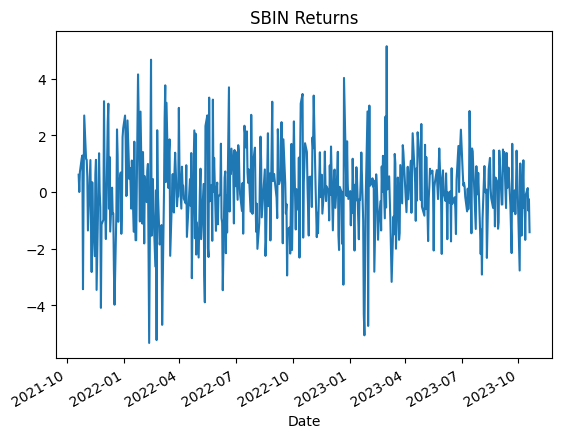

In [5]:
sbin_returns=company_list[0]['Returns']
sbin_returns.name='SBIN Returns'
sbin_returns.plot()
plt.title("SBIN Returns")
plt.show()

In [6]:
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import SMAIndicator, EMAIndicator, MACD
features = [
    'macd',
    'signal_line',
    'macd-signal',
    'rsi',
    'bb_upper',
    'bb_lower',
    'ema_10',
    'ema_20',
    'sma_50',
    'sma_200',
]

# Add difference features to the list
for indicator in ['macd', 'signal_line', 'macd-signal', 'rsi', 'bb_upper', 'bb_lower', 'sma_50', 'sma_200', 'ema_10', 'ema_20']:
    features.append(f'adj_close_{indicator}_diff')

def preprocess(data, drop_na=True):
    data = data.copy()
    
    # Calculate MACD and Signal Line
    macd_indicator = MACD(data['Adj Close'])
    data['macd'] = macd_indicator.macd()
    data['signal_line'] = macd_indicator.macd_signal()
    data['macd-signal'] = data['macd'] - data['signal_line']
    
    # Calculate RSI (Relative Strength Index)
    rsi_indicator = RSIIndicator(data['Adj Close'])
    data['rsi'] = rsi_indicator.rsi()
    
    # Calculate Bollinger Bands
    bb_indicator = BollingerBands(data['Adj Close'])
    data['bb_upper'] = bb_indicator.bollinger_hband()
    data['bb_lower'] = bb_indicator.bollinger_lband()
    
    # Calculate Simple Moving Averages (SMA)
    sma_50 = SMAIndicator(data['Adj Close'], window=50)
    sma_200 = SMAIndicator(data['Adj Close'], window=200)
    data['sma_50'] = sma_50.sma_indicator()
    data['sma_200'] = sma_200.sma_indicator()
    
    # Calculate Exponential Moving Averages (EMA)
    ema_10 = EMAIndicator(data['Adj Close'], window=10)
    ema_20 = EMAIndicator(data['Adj Close'], window=20)
    data['ema_10'] = ema_10.ema_indicator()
    data['ema_20'] = ema_20.ema_indicator()
    
    # Calculate the difference between Adj Close and each indicator
    for indicator in ['macd', 'signal_line', 'macd-signal', 'rsi', 'bb_upper', 'bb_lower', 'sma_50', 'sma_200', 'ema_10', 'ema_20']:
        data[f'adj_close_{indicator}_diff'] = data['Adj Close'] - data[indicator]
    
    if drop_na:
        data = data.dropna()
    
    return data


In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

def test_model(data,n_splits=2,):
    data = preprocess(data)
    X, y = data[features], data['Returns']
    preds_arima = []
    preds_arima_svm = []
    preds_svm = []
    actual = []

    tscv = TimeSeriesSplit(
        n_splits=n_splits, gap=0, max_train_size=None, test_size=1)
    for train_index, test_index in tscv.split(X, y):
        X_train, X_test = X.iloc[train_index, :].copy(), X.iloc[test_index, :].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()

        model_arima = ARIMA(y_train, order=(5, 2,0))
        model_arima_fitted = model_arima.fit()
        preds_arima.append(model_arima_fitted.forecast().values[0])

        model_svm=make_pipeline(StandardScaler(), SVR())
        model_svm.fit(X_train,y_train)
        preds_svm.append(model_svm.predict(X_test)[0])

        X_train['arima']=model_arima_fitted.predict()
        X_test['arima']=model_arima_fitted.forecast().values
        model_svm.fit(X_train,y_train)
        preds_arima_svm.append(model_svm.predict(X_test)[0])
        
#         X_train['arima']=model_arima_fitted.predict()
#         X_test['arima']=model_arima_fitted.forecast().values
        


        actual.append(y_test.values[0])
    return preds_arima, preds_arima_svm,preds_svm, actual
test_model(company_list[0])

([-0.834243810173567, -0.020889557540283654],
 [0.011179734285404613, -0.026517968399054487],
 [-0.016901493832703784, 0.011620498854029548],
 [-0.2532108871408645, -1.4180736078412193])

In [8]:
n_splits=10
plot_fig=False
error_metrics = []

for i,(data, name) in enumerate(zip(company_list, stock_list)):
    preds_arima, preds_arima_svm,preds_svm, actual = test_model(data,n_splits)
    if plot_fig:
        plt.figure(figsize=(10, 4))
        preds_df=pd.DataFrame({"ARIMA":preds_arima,"ARIMA-SVM":preds_arima_svm,"SVM":preds_svm,"ACTUAL":actual})
        preds_df.plot(style=['--', '--', '--'])
        plt.title(f'{name} Predictions')
        plt.legend()
        plt.show()

    
    error_metrics.append({
        "Symbol": name,
        "ARIMA MAE": mean_absolute_error(preds_arima, actual),
        "ARIMA SVM MAE": mean_absolute_error(preds_arima_svm, actual),
        "SVM MAE": mean_absolute_error(preds_svm, actual),
        "ARIMA MSE": mean_squared_error(preds_arima, actual),
        "ARIMA SVM MSE": mean_squared_error(preds_arima_svm, actual),
        "SVM MSE": mean_squared_error(preds_svm, actual),
        "ARIMA MAPE": mean_absolute_percentage_error(preds_arima, actual),
        "ARIMA SVM MAPE": mean_absolute_percentage_error(preds_arima_svm, actual),
        "SVM MAPE": mean_absolute_percentage_error(preds_svm, actual)
    })

error_metrics_df=pd.DataFrame(error_metrics)
error_metrics_df.describe()

,ARIMA MAE,ARIMA SVM MAE,SVM MAE,ARIMA MSE,ARIMA SVM MSE,SVM MSE,ARIMA MAPE,ARIMA SVM MAPE,SVM MAPE
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.665413,1.210955,1.212346,5.026288,2.890858,2.893429,5.048702,34.654149,23.439789
std,0.715995,0.431526,0.432510,4.526494,2.221715,2.223749,2.863429,54.542383,32.605757
min,0.707352,0.693657,0.688978,0.630954,0.660728,0.656283,1.993124,4.945852,5.714779
25%,1.298536,0.845266,0.849755,2.661136,1.282069,1.244025,2.753880,12.002674,9.255070
50%,1.581861,1.161671,1.164737,3.883735,2.148993,2.242198,4.543629,18.979542,11.707446
75%,1.748635,1.500597,1.473111,5.461507,4.047383,3.889494,6.149155,23.706545,19.488445
max,3.351168,1.953876,1.953264,16.529149,7.422893,7.226832,10.592449,187.790500,114.064583
